# Font type Recognition using CNN : Convolutional Neural Network

In [ ]:
! pip install --upgrade tqdm

In [1]:
import tensorflow as tf
import numpy as np
import math
%autoindent



try:
    from tqdm import tqdm, tqdm_notebook
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

### All the steps for preparing training/tresting data

* Data: 2790 36x36 images

In [2]:
# Set random seed
np.random.seed(0)

# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

# Look at some data
print(train[0])
print(labels[0])

# If you have matplotlib installed
import matplotlib.pyplot as plt
plt.ion()

def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.
    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
test, train = train[test_idx,:],\
              train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### CNN graph definition

In [3]:
sess = tf.InteractiveSession()


# These will be inputs
## Input pixels, image with one channel (gray)
x = tf.placeholder("float", [None, 36, 36])
# Note that -1 is for reshaping
x_im = tf.reshape(x, [-1,36,36,1])
## Known labels
# None works during variable creation to be
# unspecified size
y_ = tf.placeholder("float", [None,5])

In [5]:
# Conv layer 1
num_filters = 4
winx = 5
winy = 5
W1 = tf.Variable(tf.truncated_normal(
    [winx, winy, 1 , num_filters],
    stddev=1./math.sqrt(winx*winy)))
b1 = tf.Variable(tf.constant(0.1,
                shape=[num_filters]))
# 5x5 convolution, pad with zeros on edges
xw = tf.nn.conv2d(x_im, W1,
                  strides=[1, 1, 1, 1],
                  padding='SAME')
h1 = tf.nn.relu(xw + b1)
# 2x2 Max pooling, no padding on edges
p1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='VALID')

# Need to flatten convolutional output for use in dense layer
p1_size = np.product(
          [s.value for s in p1.get_shape()[1:]])
p1f = tf.reshape(p1, [-1, p1_size ])

# Dense layer
num_hidden = 32
W2 = tf.Variable(tf.truncated_normal(
     [p1_size, num_hidden],
     stddev=2./math.sqrt(p1_size)))
b2 = tf.Variable(tf.constant(0.2,
     shape=[num_hidden]))
h2 = tf.nn.relu(tf.matmul(p1f,W2) + b2)

# Output Layer
W3 = tf.Variable(tf.truncated_normal(
     [num_hidden, 5],
     stddev=1./math.sqrt(num_hidden)))
b3 = tf.Variable(tf.constant(0.1,shape=[5]))

keep_prob = tf.placeholder("float")
h2_drop = tf.nn.dropout(h2, keep_prob)

# Just initialize
#sess.run(tf.initialize_all_variables())
sess.run(tf.global_variables_initializer())

# Define model
y = tf.nn.softmax(tf.matmul(h2_drop,W3) + b3)

### ... end model specification, begin training code

In [6]:
# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
        y + 1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(
             0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1),
                              tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(
           correct_prediction, "float"))

## Train...

In [7]:
# Actually train
epochs = 5000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm_notebook(range(epochs), ascii=True):
    # Record summary data, and the accuracy
    if i % 10 == 0:  
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train,
            y_: onehot_train, keep_prob: 1.0})
        train_acc[i//10] = A
        # And now the validation set
        A = accuracy.eval(feed_dict={x: test,
            y_: onehot_test, keep_prob: 1.0})
        test_acc[i//10] = A
    train_step.run(feed_dict={x: train,
        y_: onehot_train, keep_prob: 0.5})
    
# Save the weights
saver = tf.train.Saver()
saver.save(sess, "convTest.ckpt")

print 'convTest saved!'

name='temp.npz'
np.savez_compressed(name, train_acc, test_acc)

print 'train & test accuracy saved!'


convTest saved!
train & test accuracy saved!


In [8]:
name='temp.npz'
data = np.load(name)

In [9]:
type(data)

numpy.lib.npyio.NpzFile

In [10]:
data.files

['arr_1', 'arr_0']

In [11]:
train_acc = data['arr_0']
test_acc = data['arr_1']

In [12]:
# Restore
saver = tf.train.Saver()
saver.restore(sess, "convTest.ckpt")

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for convTest.ckpt
	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]

Caused by op u'save_1/RestoreV2', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-eef586b30c9c>", line 2, in <module>
    saver = tf.train.Saver()
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1000, in __init__
    self.build()
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 624, in build
    restore_sequentially, reshape)
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 361, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 200, in restore_op
    [spec.tensor.dtype])[0])
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 441, in restore_v2
    dtypes=dtypes, name=name)
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/resources/common/.virtualenv/python2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for convTest.ckpt
	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]


In [16]:
# Check accuracy on train set
A = accuracy.eval(feed_dict={x: train,
    y_: onehot_train, keep_prob: 1.0})

print 'Training Accuracy= %s' % A

Training Accuracy= 0.720828


In [17]:
# And now the validation set
A = accuracy.eval(feed_dict={x: test,
    y_: onehot_test, keep_prob: 1.0})
print 'Test Accuracy= %s' % A

Test Accuracy= 0.659498


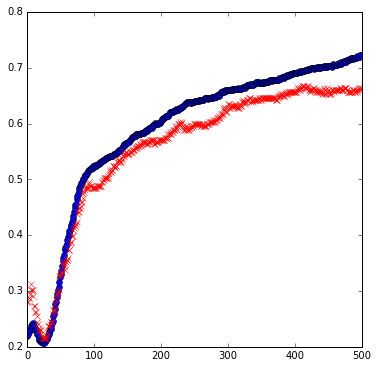

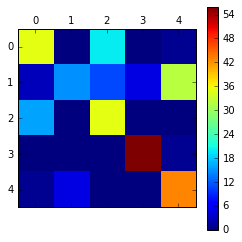

In [18]:
# Plot the accuracy curves

%matplotlib inline 
plt.figure(figsize=(6, 6))
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

# Look at the final testing confusion matrix
pred = np.argmax(y.eval(
       feed_dict={x: test, keep_prob: 1.0,
       y_: onehot_test}), axis = 1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,
                              axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

In [ ]:
# Let's look at a subplot of some weights
f, plts = plt.subplots(4)
for i in range(4):
    plts[i].matshow(
            W1.eval()[:,:,0,i])

# Examine the output weights
plt.matshow(W3.eval())
plt.colorbar()

In [ ]:
# Save the weights
saver = tf.train.Saver()
saver.save(sess, "conv1.ckpt")

In [ ]:
# Restore
saver.restore(sess, "conv1.ckpt")

In [ ]:
# Or use Numpy manually
def save_all(name = 'conv1'):
    np.savez_compressed(name, W1.eval(),
            b1.eval(), W2.eval(), b2.eval(),
            W3.eval(), b3.eval())

save_all()

In [ ]:
def load_all(name = 'conv1.npz'):
    data = np.load(name)
    sess.run(W1.assign(data['arr_0']))
    sess.run(b1.assign(data['arr_1']))
    sess.run(W2.assign(data['arr_2']))
    sess.run(b2.assign(data['arr_3']))
    sess.run(W3.assign(data['arr_4']))
    sess.run(b3.assign(data['arr_5']))

load_all()